# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema. **Listo**


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo. **Listo**


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales **Listo**.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas. **Listo**


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo. **Listo**

##1.Procesamiento de datos

####Cargamos las librerias

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.neural_network import MLPRegressor

####Construimos el conjunto de datos

In [63]:
#Cargamos el conjunto de datos y lo guardamos en un dataframe
conjuntoDatos = pd.read_csv('./Datos/diabetes.csv')
#Mostramos la descripción del conjunto de datos
conjuntoDatos.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634599e-16,1.296411e-16,-8.042209e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.575274e-16,3.780755e-16,-3.830854e-16,-3.411950e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


In [64]:
#Mostramos los cinco primeros datos para corroborar que la información esté bien organizada
conjuntoDatos.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [65]:
#Comprobamos el tipo de los datos
conjuntoDatos.dtypes

age    float64
sex    float64
bmi    float64
bp     float64
s1     float64
s2     float64
s3     float64
s4     float64
s5     float64
s6     float64
Y      float64
dtype: object

In [66]:
#Comprobamos si existen NaN en el conjunto de datos
conjuntoDatos.isnull().values.any()

False

In [67]:
#Comprobamos si existed datos duplicados
duplicados = conjuntoDatos[conjuntoDatos.duplicated(keep=False)]
duplicados.any()

age    False
sex    False
bmi    False
bp     False
s1     False
s2     False
s3     False
s4     False
s5     False
s6     False
Y      False
dtype: bool

Segun la información obtenida en los procedimientos anteriores, podemos concluir que los datos se encuentran organizados correctamente y no es necesario modificarlos

##2. Selección de variables

Inicialmente observamos la correlación que hay entre las variables, esto nos puede dar un indicio sobre que variables no son tan relevantes para nuestro modelo.


*   Dos variables están correlacionadas directamente si el coficiente de correlación toma valores muy cercanos a 1 en el intervalo [-1,1].
*    Dos variables están correlacionadasinversamente si el coficiente de correlación toma valores muy cercanos a -1 en el intervalo [-1,1].
* Si el coeficiente toma alguno de los dos valores extremos (-1 o 1) las variables se encuentran perfectamente correlacionadas.
* Si el coeficiente toma valores cercanos iguales a cero o cercanos a este en el intervalo [-1,1] significa que no hay correlación.



In [68]:
#Hallamos la correlacion de pearson
correlacion=conjuntoDatos.corr(method='pearson')
correlacion

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


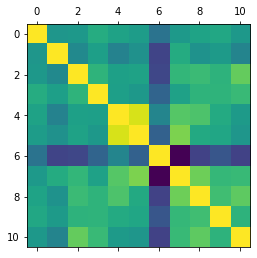

In [69]:
#Graficamos la correlacion
plt.matshow(correlacion)

Con los resultados anteriores podemos concluir:


*   Las variables s1 y s2 se encuentran correlacionadas directamente.
*   Las variables s3 y s4 se encuentran correlacionadas inversamente.

Si bien esto puede indicar que dichas variables no son relevantes para nuestro modelo, procedemos a realizar un test formal para comprobarlo.

####**Seleccion de variables**

> Para la selección de variables usamos la función RFECV, la cual se encarga de encontrar el mejor conjunto de estas, usando validación curzada.



In [70]:
#Escalamos el conjunto de datos para evitar problemas de convergenia
conjuntoEscalado = conjuntoDatos
columnas = conjuntoDatos.columns.values
escalador = StandardScaler().fit(conjuntoEscalado)
conjuntoEscalado = escalador.transform(conjuntoEscalado)
conjuntoEscalado=pd.DataFrame(conjuntoEscalado,columns=columnas)

#Dividimos el conjunto separando la Y
Y=conjuntoEscalado['Y']
X=conjuntoEscalado.drop(['Y'],1)
nombreVariables = X.columns.values

#Creamos como estimador un modelo lineal con gradiente descendente
estimador = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)

#Para la selección de variables usamos la función RFECV la cual usa
#Validación vrusada para encontrar el mejor conjunto de variables
seleccionVariables = RFECV(estimador, step=1, cv=5)
seleccionVariables = seleccionVariables .fit(X, Y)
variables = seleccionVariables.get_support(indices = True)
variablesSeleccionadas = nombreVariables[variables]
print(variablesSeleccionadas)

['sex' 'bmi' 'bp' 's3' 's5']


Con lo anterior podemos concluir que las variables mas relevantes para nuestro modelo son:


1.   sex
2.   bmi
3.   bp
4.   s3
5.   s5



####Eliminamos las variables poco importantes

In [71]:
#Eliminamos las variables que no son relevantes
conjuntoDatos.drop(['age','s1','s2','s4','s6'],axis=1,inplace=True)
conjuntoDatos.head()

,sex,bmi,bp,s3,s5,Y
0,0.050680,0.061696,0.021872,-0.043401,0.019908,151.0
1,-0.044642,-0.051474,-0.026328,0.074412,-0.068330,75.0
2,0.050680,0.044451,-0.005671,-0.032356,0.002864,141.0
3,-0.044642,-0.011595,-0.036656,-0.036038,0.022692,206.0
4,-0.044642,-0.036385,0.021872,0.008142,-0.031991,135.0


##3. Selección de una transformación

Creamos el conjunto de transformaciones

In [0]:
#Dado que el dataframe contiene un alto numero de datos negativos se probará 
#con transformaciones que admitan este tipo de datos
transformaciones = [
                   ("Exponencial", lambda X: np.exp(X)),
                   ("Cubica", lambda X: np.power(X,3)),
                   ("Cuadratica", lambda X: np.power(X,2)),
                   ("Original", lambda X: X)]

Evaluamos cada transformacion y encontramos sus metricas

In [73]:
#Creamos un dataframe para almacenar el conjunto de datos
resultados = pd.DataFrame(columns = ["Transformación","SSE","MAE","MSE","RMSE"])
#Se evalua cada transformacion en el conjunto de datos
for nombreTransformacion, transformacion in transformaciones:
    #Aplicamos la transformacion
    modelo = conjuntoDatos.apply(transformacion)
    #Dividimos los datos en entrenamiento y prueba, escogiendo un 20%
    #de los datos para pruebas
    X_train, X_test, y_train, y_test = train_test_split(modelo.drop(['Y'], axis=1), 
                                                        modelo['Y'], test_size=0.20)
    #Creamos la regresión lineal
    lm = LinearRegression()
    #Entrenamos la regresión
    lm.fit(X_train,y_train)
    #Predecimos
    predicciones = lm.predict(X_test)
    
    #Encontramos los errores al cuadrado
    errores2 = (y_test - predicciones) ** 2

    #Calculamos las metricas y las guardamos
    resultados = resultados.append({
                    "Transformación": nombreTransformacion ,
                    "SSE": np.sum(errores2),
                    "MAE": metrics.mean_absolute_error(y_test, predicciones),
                    "MSE": metrics.mean_squared_error(y_test, predicciones),
                    "RMSE": np.sqrt(metrics.mean_squared_error(y_test, predicciones)),
                },ignore_index=True)

#Imprimimos el conjunto de resultados
resultados

,Transformación,SSE,MAE,MSE,RMSE
0,Exponencial,3.400819e+300,2.080597e+148,3.821145e+298,1.954775e+149
1,Cubica,3.859553e+15,4.797744e+06,4.336577e+13,6.585269e+06
2,Cuadratica,6.095782e+10,2.057066e+04,6.849193e+08,2.617096e+04
3,Original,3.422243e+05,5.180089e+01,3.845217e+03,6.200982e+01


Escogemos la transformacion con errores mas pequeños

In [74]:
mejorTransformacion = resultados[resultados['MSE']==min(resultados['MSE'])]
mejorTransformacion

,Transformación,SSE,MAE,MSE,RMSE
3,Original,342224.337729,51.800887,3845.217278,62.009816


De lo anterior podemos observar que la mejor transformación es 'Original', la cual corresponde a los datos iniciales sin alterar, por lo tanto concluimos que no es necesario aplicar ninguna transformación.

####4. Modelo de regresión lineal

ECM = 2930.1839942677084


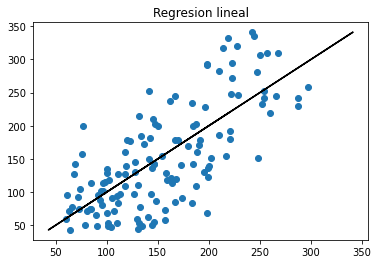

In [75]:
#Dividimos los datos en entrenamiento y prueba, escogiendo un 30%
#de los datos para pruebas
X_train, X_test, y_train, y_test = train_test_split(conjuntoDatos.drop(['Y'], axis=1), 
                                                        conjuntoDatos['Y'], test_size=0.30)

#Creamos la regresión lineal
lm = LinearRegression()

#Entrenamos la regresión
lm.fit(X_train,y_train)

#Predecimos
predicciones = lm.predict(X_test)
    
#Encontramos los errores al cuadrado
errores2 = (y_test - predicciones) ** 2

plt.scatter(predicciones, y_test)
plt.plot(y_test, y_test, color='black')
plt.title('Regresion lineal')

print('ECM = '+ str(metrics.mean_squared_error(y_test, predicciones)))

**Robustez del modelo de regresión lineal con validación cruzada:**

In [76]:
resultadosValidacion = cross_val_score(lm, X_train, y_train, cv=10)
print("Resultado: %0.2f (+/- %0.2f)" % (resultadosValidacion.mean(), resultadosValidacion.std() * 2))

Resultado: 0.47 (+/- 0.19)


##5. Modelo de redes neuronales

Escalamos los datos para ser usados en la red neuronal

In [0]:
#Creamos el escalador
escalador = MinMaxScaler()
#Obtenemos el nombre de las columnas del conjunto de datos original
columnas=conjuntoDatos.columns

#Creamos un conjunto auxiliar donde escalaremos los datos del dataframe original
conjuntoEscalado=pd.DataFrame(escalador.fit_transform(conjuntoDatos),columns=columnas)
conjuntoEscalado.head(3)

#Sepparamos las variables independientes de la variable dependiente
X=conjuntoEscalado.drop(['Y'],1)
Y=conjuntoEscalado['Y']

In [78]:
#Creamos el de redes neuronales con un valor inicial de 5 neuronas
m = MLPRegressor(hidden_layer_sizes=(8, ),
                activation = 'relu',
                learning_rate = 'adaptive',
                momentum = 0.9,
                solver= 'sgd',
                learning_rate_init = 0.01,
                max_iter = 1000)

#Separamos los datos dejando un 70% para entrenamiento y un 30% para pruebas
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

#Entrenamos la red
m.fit(X_train,  y_train.values.ravel())

#Predecimos
prediccion=m.predict(X_test)

#Creamos otros dos conjuntos de datos, uno con las predicciones y otro con el Y
#de pruebas para poder comparar el error
conjuntoPredicho=pd.DataFrame(X_test,columns=columnas[0:-1])
conjuntoNormal=conjuntoPredicho[['sex','bmi','bp','s3','s5']]
conjuntoPredicho[columnas[-1]]=prediccion
conjuntoNormal[columnas[-1]]=y_test

#Invertimos el escalado del conjunto de datos
conjuntoPredicho=pd.DataFrame(escalador.inverse_transform(conjuntoPredicho),columns=columnas)
conjuntoNormal=pd.DataFrame(escalador.inverse_transform(conjuntoNormal),columns=columnas)

#Mostramos el error cuadratico medio
print('ECM = '+ str(metrics.mean_squared_error(conjuntoNormal['Y'],conjuntoPredicho['Y'])))



ECM = 3377.84577301346


Notamos el que resultado del error con redes neuronales no mejora respecto al resultado de regresión lineal, por lo cual procedemos a buscar el número optimo de neuronas.

Creamos la red neuronal e iteramos para encontrar el numero optimo de neuronas que hagan que nuestro modelo tenga el error cuadratico medio mas pequeño.

In [0]:
#Creamos el conjunto de datos datos para guardar las neuronas y el error cuadratico
#Medio asosciado a la red neuronal con dicho numero de neuronas
neuronas=pd.DataFrame(columns=['Neuronas','ECM'])

#Iteramos sobre el numero de neuronas
for numeroNeuronas in range(1,50):
  m = MLPRegressor(hidden_layer_sizes=(numeroNeuronas, ),
                  activation = 'relu',
                  learning_rate = 'adaptive',
                  momentum = 0.9,
                  solver= 'sgd',
                  learning_rate_init = 0.01,
                  max_iter = 1000)

  #Separamos los datos dejando un 70% para entrenamiento y un 30% para pruebas
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

  #Entrenamos la red
  m.fit(X_train,  y_train.values.ravel())

  #Predecimos
  prediccion=m.predict(X_test)

  #Creamos otros dos conjuntos de datos, uno con las predicciones y otro con el Y
  #de pruebas para poder comparar el error
  conjuntoPredicho=pd.DataFrame(X_test,columns=columnas[0:-1])
  conjuntoNormal=conjuntoPredicho[['sex','bmi','bp','s3','s5']]
  conjuntoPredicho[columnas[-1]]=prediccion
  conjuntoNormal[columnas[-1]]=y_test

  #Invertimos el escalado del conjunto de datos
  conjuntoPredicho=pd.DataFrame(escalador.inverse_transform(conjuntoPredicho),columns=columnas)
  conjuntoNormal=pd.DataFrame(escalador.inverse_transform(conjuntoNormal),columns=columnas)

  #Guardamos la información del numero de neuronas y el ECM
  ECM=metrics.mean_squared_error(conjuntoNormal['Y'],conjuntoPredicho['Y'])
  neuronas = neuronas.append({
                    "Neuronas": numeroNeuronas ,
                    "ECM": ECM
                },ignore_index=True)

A continuación buscamos el conjunto de neuronas que nos den el minimo error cuadratico medio.

In [80]:
neuronasOptimas = neuronas[neuronas['ECM']==min(neuronas['ECM'])]
neuronasOptimas

,Neuronas,ECM
38,39.0,2474.779393


Posteriormente procedemos a añadir otra capa y vemos si el desempeño mejora, con la finalidad de observar si el numero de capas ocultas afecta notoriamente.

In [0]:
neuronas2Capas=pd.DataFrame(columns=['Neuronas capa 1','Neuronas capa 2','ECM'])

for numeroNeuronasC1 in range(1,50):
  for numeroNeuronasC2 in range(1,50):
    m = MLPRegressor(hidden_layer_sizes=(numeroNeuronasC1,numeroNeuronasC2, ),
                    activation = 'relu',
                    learning_rate = 'adaptive',
                    momentum = 0.9,
                    solver= 'sgd',
                    learning_rate_init = 0.01,
                    max_iter = 1000)

    #Separamos los datos dejando un 70% para entrenamiento y un 30% para pruebas
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    #Entrenamos la red
    m.fit(X_train,  y_train.values.ravel())

    #Predecimos
    prediccion=m.predict(X_test)

    #Creamos otros dos conjuntos de datos, uno con las predicciones y otro con el Y
    #de pruebas para poder comparar el error
    conjuntoPredicho=pd.DataFrame(X_test,columns=columnas[0:-1])
    conjuntoNormal=conjuntoPredicho[['sex','bmi','bp','s3','s5']]
    conjuntoPredicho[columnas[-1]]=prediccion
    conjuntoNormal[columnas[-1]]=y_test

    #Invertimos el escalado del conjunto de datos
    conjuntoPredicho=pd.DataFrame(escalador.inverse_transform(conjuntoPredicho),columns=columnas)
    conjuntoNormal=pd.DataFrame(escalador.inverse_transform(conjuntoNormal),columns=columnas)

    #Guardamos la información del numero de neuronas y el ECM
    ECM=metrics.mean_squared_error(conjuntoNormal['Y'],conjuntoPredicho['Y'])
    neuronas2Capas = neuronas2Capas.append({
                      "Neuronas capa 1": numeroNeuronasC1 ,
                      "Neuronas capa 2": numeroNeuronasC2 ,
                      "ECM": ECM
                  },ignore_index=True)
  

A continuación buscamos el conjunto de neuronas que nos den el minimo error cuadratico medio.

In [82]:
neuronasOptimas = neuronas2Capas[neuronas2Capas['ECM']==min(neuronas2Capas['ECM'])]
neuronasOptimas

,Neuronas capa 1,Neuronas capa 2,ECM
2169,45.0,14.0,2261.355157


Como podemos observar el numero de capas ocultas afecta positivamente el desempeño del modelo de redes neuronales, lo cual se refleja en una disminución notoria del ECM.

**Robustez del modelo de redes neuronales con validación cruzada:**

In [83]:
resultadosValidacionRn = cross_val_score(m, X_train, y_train, cv=10)
print("Resultado: %0.2f (+/- %0.2f)" % (resultadosValidacionRn.mean(), resultadosValidacionRn.std() * 2))

Resultado: 0.44 (+/- 0.22)


##Conclusiones

De los resultados anteriores podemos concluir que:


1.   Aunque los resultados de la regresión lineal no son los mas optimos en cuanto al ECM esta nos permitió crear un buen modelo para la red neuronal.

2.   El modelo de redes neuronales con una capa tiene un mejor desempeño que la regresión lineal, pero es necesario buscar el numero de neuronas optimas para que esto sea notorio.

3.   La red neuronal con dos capas tuvo el mejor desempeño, disminuyendo notoriamente el ECM, lo cual nos puede indicar que el numero de capas ocultas tiene una influencia positiva en el desempeño, pero también debemos tener en cuenta que debemos lidiar con el coste computacional que supone aumentar su numero.

4.   Respecto a la robustez del modelo cabe destacar que segun la validación cruzada tanto el modelo de regresión lineal como el modelo de redes neuronales son similares en este aspecto, dando resultados bastante altos, lo cual junto con el ECM nos indica que aún los modelos presentan una baja precisión, por lo cual debería ser refinados en cuanto a los demás parametros.

5.   Para finalizar se concluye que si bien el modelo de Redes neuronales con dos capas no tiene un desempeño supremamente bueno, con este ejercicio pudimos comprobar que se comporta mejor que los demás.